# Pixie

### Initialize

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/11 16:22:09 WARN Utils: Your hostname, amin-X556UQK resolves to a loopback address: 127.0.1.1; using 172.20.0.1 instead (on interface br-13093d199dae)
22/02/11 16:22:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/11 16:22:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



##### Remove 8th day

In [3]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



### Main Code

##### Keep high traffic cars

<h5 dir="rtl">
 در این مرحله تنها ماشین‌های پرتردد را نگه می‌داریم. همچنین داده‌های پرت را نیز حذف می‌کنیم. 
</h5> 


In [4]:
car_counts = df.groupBy('FINAL_CAR_KEY').count()
traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(1000)
traffic_cars = [x.FINAL_CAR_KEY for x in traffic_cars]
top_cars_df = df.filter(df.FINAL_CAR_KEY.isin(traffic_cars))
print(top_cars_df.count())
top_cars_df.show(5)

22/02/11 16:26:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 16:26:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 16:26:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 16:26:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


212498
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     206602|       81|        8334658|      8334658|               5|       161|2021-06-01 04:09:16|152|
|     211901|       81|        8447803|      8447803|               5|       161|2021-06-01 03:12:10|152|
|     206601|       81|        8683677|      8683677|               5|       161|2021-06-01 04:01:34|152|
|     205202|       81|        7826265|      7826265|               5|       161|2021-06-01 03:50:18|152|
|     631763|       81|        9026234|      9026234|               5|       161|2021-06-01 02:42:56|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 5 rows



<h5 dir="rtl">
 این مرحله، 
 df
 را به صورتی در می‌آورد که نشان‌دهنده‌ی یال‌های گراف ما باشد.  
</h5> 


In [5]:
camera_car_df = top_cars_df.groupBy('DEVICE_CODE', 'FINAL_CAR_KEY').count()
camera_car_df.show(5)

+-----------+-------------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|count|
+-----------+-------------+-----+
|     203902|      8358717|  173|
|     631832|      7671807|    5|
|     631829|     10286523|    3|
|     212802|     65021527|   14|
|     631795|      7646099|    8|
+-----------+-------------+-----+
only showing top 5 rows



<h5 dir="rtl">
 سپس ماشین‌ها و دوربین‌ها را اندیس گذاری می‌کنیم.  
</h5> 


In [6]:
from pyspark.ml.feature import StringIndexer

camera_car_indexed_df = StringIndexer(inputCol='FINAL_CAR_KEY', outputCol='CAR_INDEX').fit(camera_car_df).transform(camera_car_df)
camera_car_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='CAMERA_INDEX').fit(camera_car_indexed_df).transform(camera_car_indexed_df)

camera_car_indexed_df.show(5)

+-----------+-------------+-----+---------+------------+
|DEVICE_CODE|FINAL_CAR_KEY|count|CAR_INDEX|CAMERA_INDEX|
+-----------+-------------+-----+---------+------------+
|     203902|      8358717|  173|    995.0|        89.0|
|     631832|      7671807|    5|    355.0|        75.0|
|     631829|     10286523|    3|     86.0|        21.0|
|     212802|     65021527|   14|    735.0|        66.0|
|     631795|      7646099|    8|    305.0|        34.0|
+-----------+-------------+-----+---------+------------+
only showing top 5 rows



<h5 dir="rtl">
 حال در دو
 rdd
 متفاوت، یال‌های خارج شونده‌ از هر ماشین، و هر دوربین را نگه می‌داریم. 
</h5> 


In [7]:
cars_edges = camera_car_indexed_df.rdd.map(lambda x: (int(x.CAR_INDEX), int(x.CAMERA_INDEX))).groupByKey().mapValues(list).sortByKey()
camera_edges = camera_car_indexed_df.rdd.map(lambda x: (int(x.CAMERA_INDEX), int(x.CAR_INDEX))).groupByKey().mapValues(list).sortByKey()
CAR_COUNT = cars_edges.count()
CAMERA_COUNT = camera_edges.count()
# cars_edges.take(2)
# camera_edges.take(2)

<h5 dir="rtl">
 اکنون با استفاده از الگوریتم 
 Pixie
 می‌توانیم نزدیک ترین دوربین به هر دوربین دیگر را به دست آوریم. در مورد معنی «نزدیک ترین» در مستند ارائه شده در بخش 
 Pixie
 صحبت کرده‌ام. دوربین کوئری من به صورت رندم انتخاب شده است (متغیر
 query_camera).
</h5> 


<h5 dir="rtl">
 متغیر 
 alpha
 نشان دهنده‌ی احتمالی است که به راس اولیه بازمی‌گردیم. تعداد مراحل الگوریتم نیز با متغیر 
 steps
 مشخص می‌شود. 
</h5> 


In [45]:
query_camera = 400
query_car = 300
STEPS = 1000

In [46]:
import os
import random

os.environ['PYTHONHASHSEED'] = '0'

def pixie(query_camera, steps=1000):
    camera_scores = [0]*CAMERA_COUNT

    related_camera = query_camera
    alpha = 0.2
    for i in range(steps):
        if i%100 == 0:
            print('i is: ',i)

        related_car = camera_edges.lookup(query_camera)[0]
        r = random.randint(0, len(related_car)-1)
        related_car = related_car[r]

        related_camera = cars_edges.lookup(related_car)[0]
        r = random.randint(0, len(related_camera)-1)
        related_camera = related_camera[r]
        camera_scores[related_camera] += 1

        r = random.random()
        if r < alpha:
            related_camera = query_camera

    return camera_scores

def pixie_on_cars(query_car, steps=1000):
    car_scores = [0]*CAR_COUNT

    related_car = query_car
    alpha = 0.2
    for i in range(steps):
        if i%100 == 0:
            print('i is: ',i)

        related_camera = camera_edges.lookup(query_camera)[0]
        r = random.randint(0, len(related_camera)-1)
        related_camera = related_camera[r]

        related_car = cars_edges.lookup(related_car)[0]
        r = random.randint(0, len(related_car)-1)
        related_car = related_car[r]
        car_scores[related_car] += 1

        r = random.random()
        if r < alpha:
            related_car = query_car

    return car_scores




In [47]:
def get_top_k(input_list, k, remove=None):
    top_k = sorted([(i,x) for i,x in enumerate(input_list)], key = lambda x: -x[1])[:k+1]
    if remove:
        for x in top_k:
            if x[0] == remove:
                top_k.remove(x)
                return top_k
    else:
        top_k = top_k[:k]
    return top_k

In [48]:
camera_scores = pixie(query_camera, STEPS)

i is:  0
i is:  100
i is:  200
i is:  300
i is:  400
i is:  500
i is:  600
i is:  700
i is:  800
i is:  900


<h5 dir="rtl">
 تابع زیر یک لیست را به صورت یک نمودار میله‌ای نمایش می‌دهد. 
</h5> 


In [49]:
from matplotlib import pyplot as plt
def plot_barchart(input_list, title=None):
    fig = plt.figure(figsize = (40, 10))
    labels = list(map(lambda x: str(x), range(len(input_list))))
    plt.bar(labels, input_list, color='red', width = 0.7)
    plt.xticks(rotation='vertical',fontsize=10)
    if title:
        plt.title(title)
    plt.show()

<h5 dir="rtl">
 در این مرحله‌ نتیجه‌ی اجرای الگوریتم برای یک دوربین دلخواه نمایش داده‌شده است. 
</h5> 


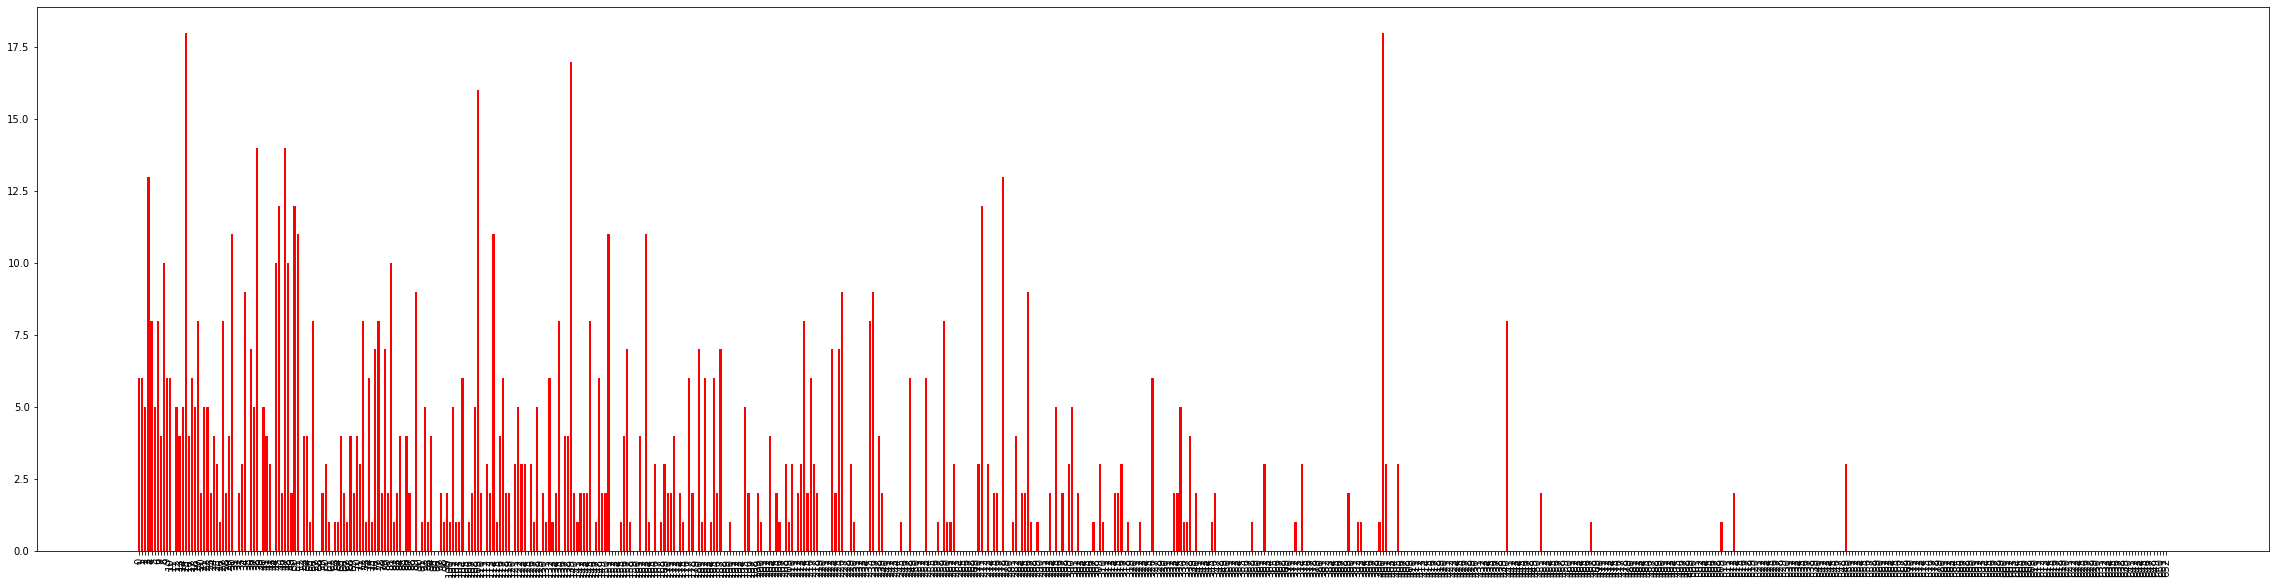

In [50]:
plot_barchart(camera_scores)

In [51]:
top_k = get_top_k(camera_scores, 10, 400)

print(top_k)

[(15, 18), (139, 17), (109, 16), (38, 14), (47, 14), (3, 13), (278, 13), (45, 12), (50, 12), (271, 12)]


In [52]:
camera_scores2 = pixie(top_k[0][0], STEPS)

i is:  0
i is:  100
i is:  200
i is:  300
i is:  400
i is:  500
i is:  600
i is:  700
i is:  800
i is:  900


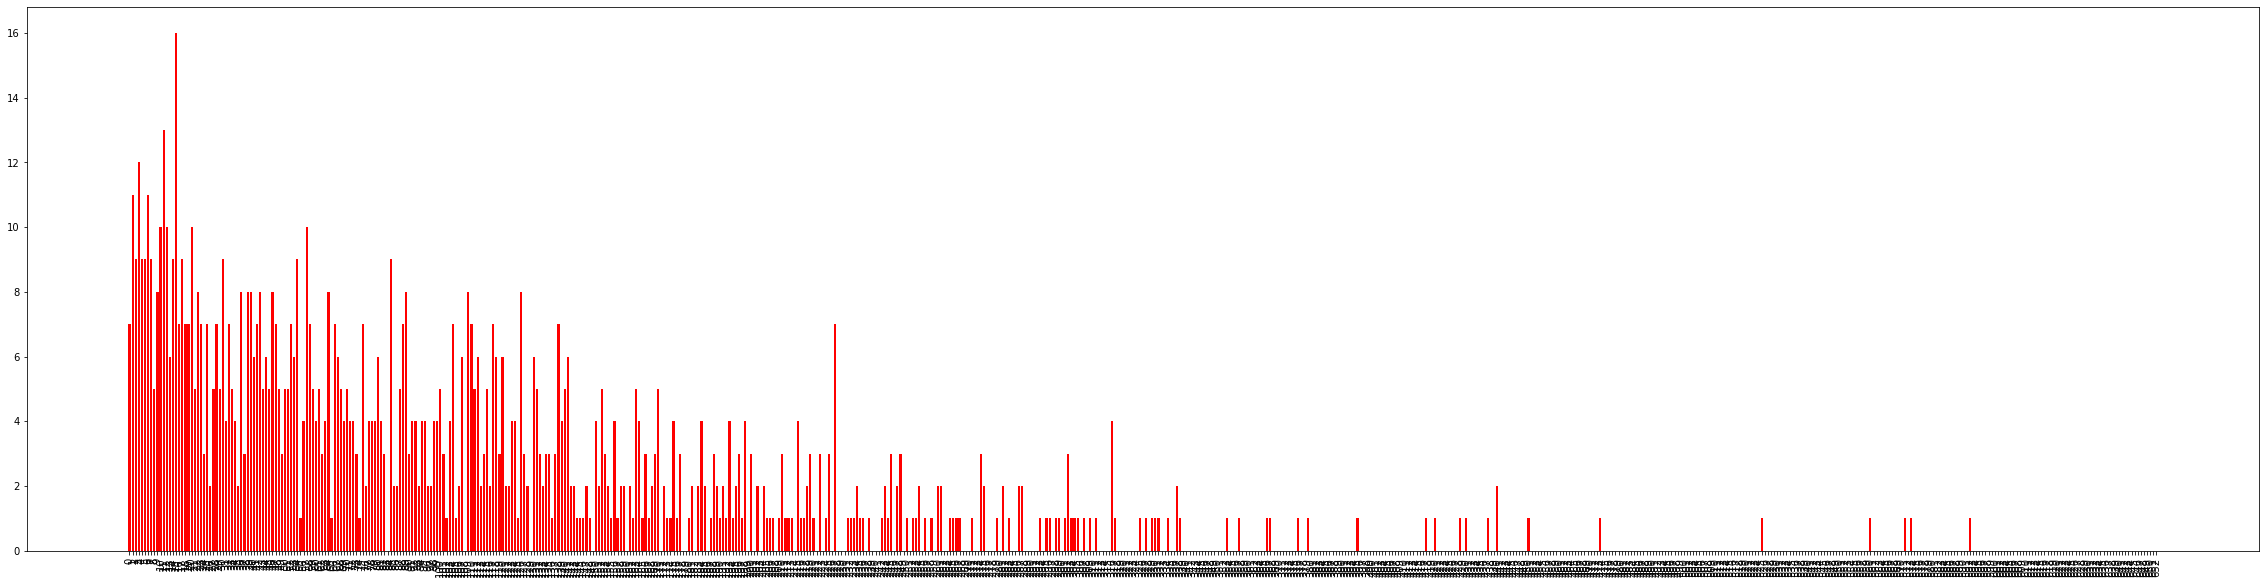

In [53]:
plot_barchart(camera_scores2)

<h5 dir="rtl">
 حال مشابه همان کار را برای یک ماشین دلخواه انجام می‌دهیم. راجب معنی این نمودار‌ها در مستند توضیح داده‌ام. 
</h5> 


In [18]:
car_scores = pixie_on_cars(query_car, STEPS)

i is:  0
i is:  100
i is:  200
i is:  300
i is:  400
i is:  500
i is:  600
i is:  700
i is:  800
i is:  900


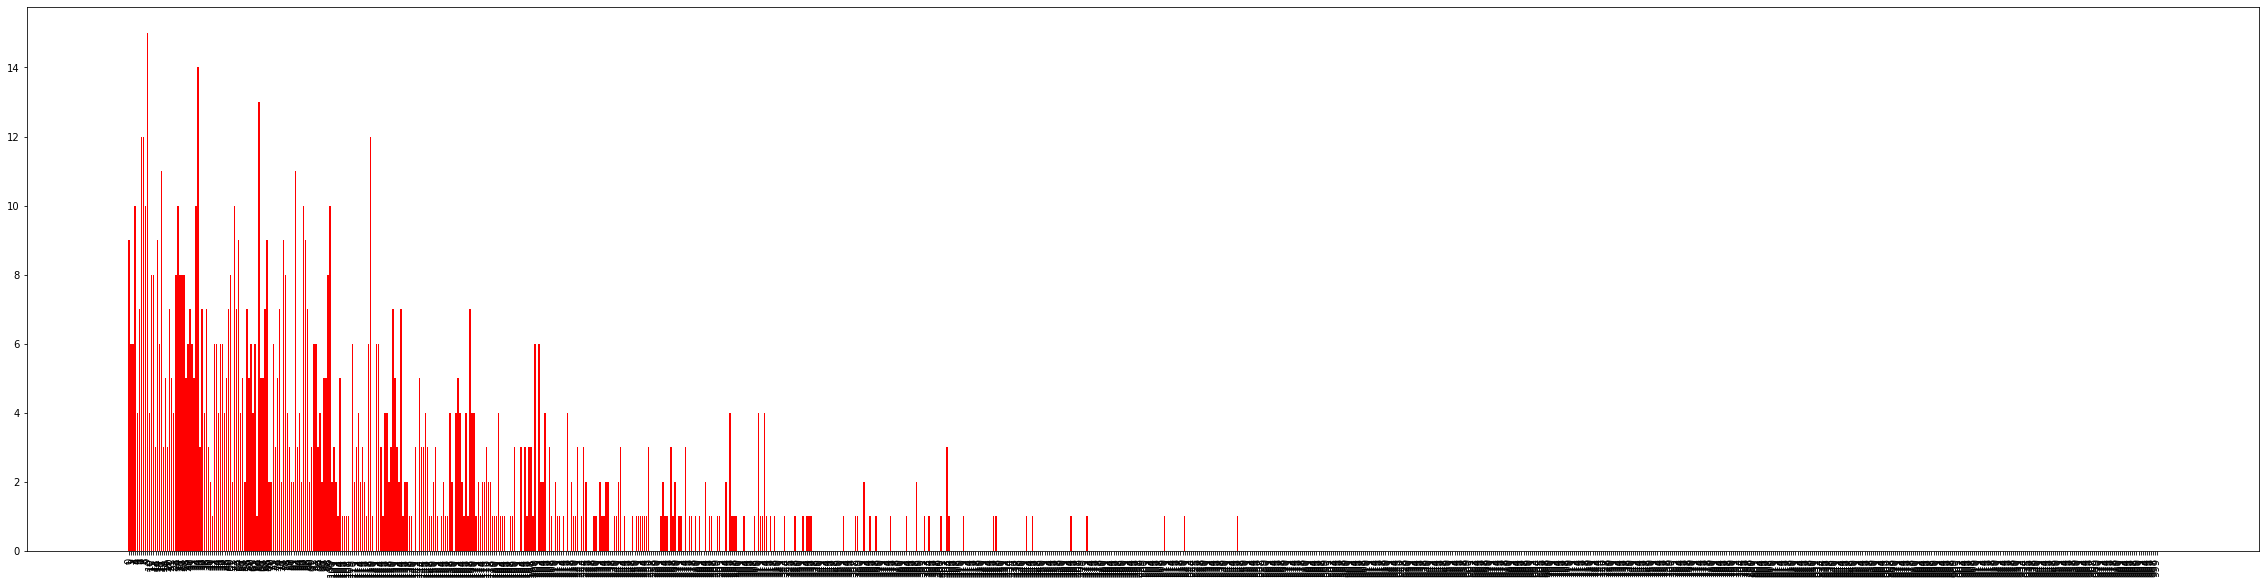

In [36]:
plot_barchart(car_scores)

<h5 dir="rtl">
 در این قسمت نوع «نزدیک»ترین دوربین‌ها به دوربین کوئری را چاپ کرده‌ام. توضیحات لازم را در مستند نوشته‌ام.  
</h5> 


In [44]:
def get_device_code(camera_index):
    device_code = camera_car_indexed_df.filter(camera_car_indexed_df.CAMERA_INDEX == camera_index).take(1)[0]['DEVICE_CODE']
    return device_code

def get_system_id(device_code):
    system_id = top_cars_df.filter(top_cars_df.DEVICE_CODE == device_code).take(1)[0]['SYSTEM_ID']
    return system_id

def get_system_id_from_index(camera_index):
    dc = get_device_code(camera_index)
    si = get_system_id(dc)
    return si

print(get_system_id_from_index(query_camera))
for k in top_k:
    print(get_system_id_from_index(k[0]))



81


283


283


283


81


283


81


81


81


283


283
